> Martin Fridrich, 03/2021

# Predicting user churn with various classifiers

This document strives to propose, implement, and benchmark machine learning solutions to the user churn prediction problem. For such a task, we utilize original user churn model formed in the previous step. The endevours are structured as follows:

1 [Housekeepin'](#housekeepin)  
2 [Classification pipeline](#classification-pipeline)  
3 [Experimental design & fitting](#experimental-design--fitting)  
4 [Overview](#overview)  
5 [Bias-variance tradeoff](#bias-variance-tradeoff)  
4 [ROC-AUC curves](#roc-auc-curves)  
5 [Next steps](#next-steps)  

# Housekeepin'

In the opening section, we load most of the libs and the `user-churn-model-data.csv`. Also, we downcasted the numerical columns.

In [1]:
# set options
import warnings  
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("notebook_repr_html", False)

# general
import numpy as np
from scipy.stats import ttest_rel, wilcoxon
from itertools import permutations
from collections import OrderedDict
import pickle

# plotting
from cairosvg import svg2png
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns

# pipes & pints
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold

# preprocessing & dr
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# clfs
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# others
from sklearn.calibration import CalibratedClassifierCV
from sklearn.kernel_approximation import  Nystroem
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.dpi'] = 450

# metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score,\
f1_score, roc_auc_score, roc_curve

In [2]:
def downcast_dtype(column_series):
    """Try to infer better dtype.
    
        Parameters>
            column_series: pd.Series, a column to down
            
        Returns>
            pd.Series, converted column"""        
    
    conv_dict = {"int":"integer", "float":"float"}
    for k in conv_dict.keys():
        if k in str(column_series.dtype):
            return pd.to_numeric(column_series, downcast=conv_dict[k])

In [3]:
# data load
classification_data = pd.read_csv("../data/ecom-user-churn-data.csv")
classification_data = classification_data.loc[:,"ses_rec":"target_class"]
classification_data = classification_data.apply(downcast_dtype, axis=0)
features = classification_data.loc[:,"ses_rec":"int_cat24_n"].columns

# Classification pipeline

We tackle the user churn prediction problem with a machine learning pipeline, which consists of the following blocks (1) data processing, (2) feature extraction, and (3) classification. We remove explanatory variables with low variance in the first block, scaled them with quantile transformer, and extend the original feature space with 2nd degree polynoms & interactions. For the second block, we use principal component analysis to remove autocorrelation. The last block is dedicated to the classification with logistic regression, multi-layer perceptron, support vector machine & ensembles.

In [4]:
tran = [("nzv", VarianceThreshold()), ("scale",QuantileTransformer()),
    ("poly", PolynomialFeatures()), ("dr", PCA(n_components=50))]

clf = {"lr":LogisticRegression(solver="liblinear"), "mlp":MLPClassifier(), "svm-lin":CalibratedClassifierCV(LinearSVC()),
    "svm-rbf":[("rbf", Nystroem(random_state=2021)), ("clf", CalibratedClassifierCV(LinearSVC()))], # speed up the rbf
    "rf":RandomForestClassifier(), "gbm":GradientBoostingClassifier()}

pipelines = OrderedDict((k, Pipeline(tran+c)) if isinstance(c, list) else (k, Pipeline(tran+[("clf",c)])) for k,c in clf.items())

# Experimental design & fitting

To evaluate the pipelines, we employ a robust procedure based on stratified 20-fold cross-validation, where pipeline performance is evaluated with respect to accuracy, precision, recall, f1, roc_auc, and fitting time. 

In [5]:
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state=2021)
scoring_metrics = {'acc': "accuracy", "pre":"precision","rec":"recall",
    "f1":"f1", "auc":"roc_auc"}

score_dict = {k:cross_validate(p,
    X=classification_data.loc[:,features],
    y=classification_data.target_class, 
    cv=skf,
    scoring=scoring_metrics, n_jobs=8, return_train_score=True,
    return_estimator=True, error_score=0)
        for k,p in pipelines.items()}

for k in score_dict.keys():
    score_dict[k]["pipe"] = np.repeat(k, skf.get_n_splits())
    
score_df = pd.concat([pd.DataFrame.from_dict(s)
    for s in score_dict.values()]) 

# Overview

In the following chunk we compute point estimates and confidence intervals for the performance metrics and computational time.

In [6]:
def get_ci(df, ignore):
    cols = [c for c in df.columns if c not in set(ignore)]
    mju, scaler = df[cols].mean().values, df[cols].std()/np.sqrt(df.shape[0])
    hi, low = mju + 1.96 * scaler, mju - 1.96 * scaler
    output_dict = dict(**dict(zip(["mju_"+ c for c in cols], mju)),
        **dict(zip(["hi_"+ c for c in cols], hi)),
        **dict(zip(["low_"+ c for c in cols], low)))
    return pd.Series(output_dict,
                index=output_dict.keys())

pipe_order = pipelines.keys()

score_df.groupby("pipe").apply(get_ci, ignore=["pipe", "estimator"]).to_csv("../data/ecom-user-churn-bench.csv")
score_df.groupby("pipe").apply(get_ci, ignore=["pipe", "estimator"]).loc[:,
    ["mju_test_acc", "mju_test_pre", "mju_test_rec", "mju_test_f1", "mju_test_auc", "mju_fit_time"]].\
    loc[pipe_order,:].reset_index()

      pipe  mju_test_acc  mju_test_pre  mju_test_rec  mju_test_f1  \
0       lr      0.889440      0.891772      0.996042     0.941027   
1      mlp      0.878662      0.898509      0.972890     0.934211   
2  svm-lin      0.888752      0.892646      0.993915     0.940561   
3  svm-rbf      0.887901      0.892425      0.993137     0.940090   
4       rf      0.886381      0.893784      0.989270     0.939104   
5      gbm      0.889076      0.893280      0.993434     0.940698   

   mju_test_auc  mju_fit_time  
0      0.737427      6.761301  
1      0.682676     45.929678  
2      0.731656    115.718642  
3      0.734547     14.639811  
4      0.709684     71.027486  
5      0.742580    110.002547  

From the point estimates, we can see that prediction performance on test part of the data is acceptable and comparable across the classifiers. The promising results are yielded by `lr`, `svm-rbf` & `gbm`, while `lr` being 2-20 times faster. In addition to the plain point estimates, we employ a t-test and couple the observations on cv folds to compare the results. Tests will be evaluated on raw alpha 0.01 and further adjusted with Bonferroni correction.

In [7]:
# do tests on f1 & auc roc
perms = list(permutations(score_df["pipe"].unique(),2))
dims = ["test_acc", "test_f1", "test_auc"]
test_ls = []
for tc in perms:
    for td in dims:
        cf = [cf for cf in score_df.columns if td in cf]
        stat, pval = ttest_rel(score_df.loc[score_df["pipe"]==tc[0],cf].values[:,0],
            score_df.loc[score_df["pipe"]==tc[1],cf].values[:,0])
        mju0 = score_df.loc[score_df["pipe"]==tc[0],cf].values.mean()
        mju1 = score_df.loc[score_df["pipe"]==tc[1],cf].values.mean()
        test_ls.append([tc[0], tc[1], td.split("_")[0], td.split("_")[1], mju0-mju1, pval])
test_df = pd.DataFrame(test_ls, columns=["from", "to", "set","metric", "diff", "pval"])
test_df.to_csv("../data/ecom-user-churn-bench-tests.csv")

# peek at the statistically significant diffs on adjusted p-val
test_df[(test_df.pval*test_df.shape[0]/2<0.01)]

       from       to   set metric      diff          pval
0        lr      mlp  test    acc  0.010778  2.596958e-08
1        lr      mlp  test     f1  0.006816  4.638626e-09
2        lr      mlp  test    auc  0.054751  6.336750e-13
5        lr  svm-lin  test    auc  0.005771  3.259581e-07
9        lr       rf  test    acc  0.003059  3.390936e-05
10       lr       rf  test     f1  0.001922  5.368318e-06
11       lr       rf  test    auc  0.027743  8.569724e-09
15      mlp       lr  test    acc -0.010778  2.596958e-08
16      mlp       lr  test     f1 -0.006816  4.638626e-09
17      mlp       lr  test    auc -0.054751  6.336750e-13
18      mlp  svm-lin  test    acc -0.010089  7.295259e-08
19      mlp  svm-lin  test     f1 -0.006351  1.458463e-08
20      mlp  svm-lin  test    auc -0.048980  5.249305e-12
21      mlp  svm-rbf  test    acc -0.009239  2.504055e-07
22      mlp  svm-rbf  test     f1 -0.005879  4.905994e-08
23      mlp  svm-rbf  test    auc -0.051871  3.622657e-11
24      mlp   

The test results support the observation made with the previous data. There appears to be significant difference between the `svm-rbf`, and `gbm` with wrt auc.

# Bias-variance tradeoff

Now, let us inspect the generalization ability of the classifiers.

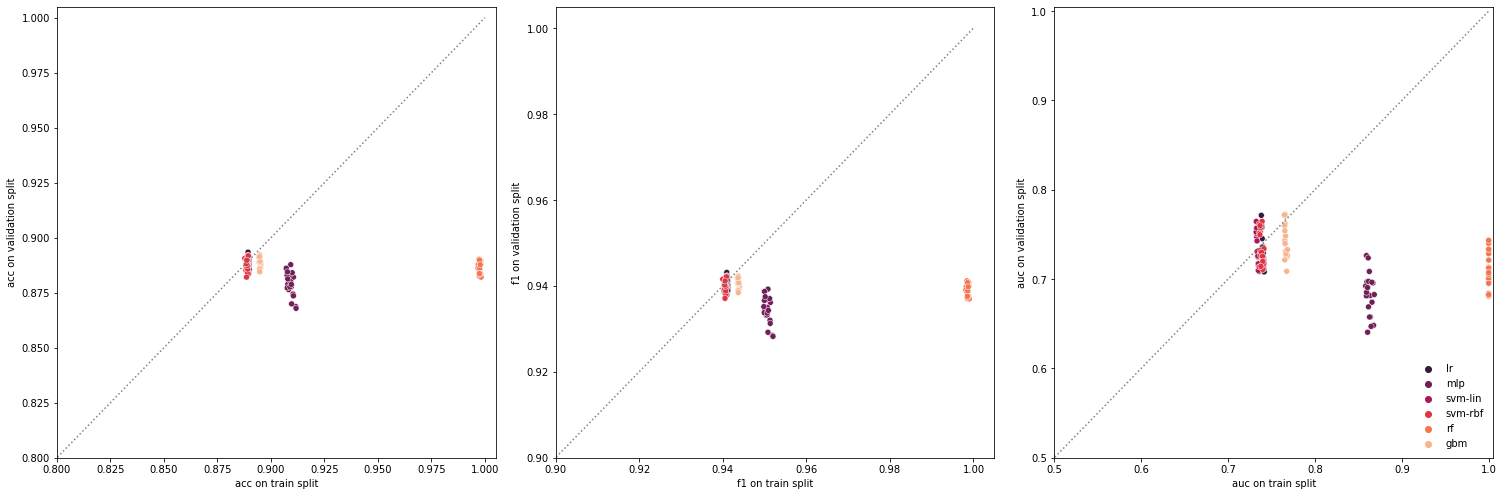

In [8]:
fig, axs = plt.subplots(1,3, figsize=(21,7))
mets = {"acc":(0.8,1.005), "f1":(0.9,1.005), "auc":(0.5,1.005)}
pipe_order = ["lr", "svm-lin", "svm-rbf", "mlp", "rf", "gbm"]

for m, ax in zip(mets.keys(), axs):
    sns.scatterplot("train_"+m,"test_"+m, marker="o",
        hue="pipe", hue_order=pipe_order, palette="rocket",
        data=score_df[[c for c in score_df.columns if (m in c) or ("pipe" in c)]],
        ax=ax);

    sns.lineplot([0,1],[0,1], color="gray", ax=ax, linestyle="dotted");
    ax.set_xlim(mets[m]);
    ax.set_ylim(ax.set_xlim());
    ax.set_xlabel(m+" on training split");
    ax.set_ylabel(m+" on validation split");
    ax.legend_.remove();

ax.legend(loc="lower right", frameon=False);
fig.tight_layout();

We see that `mlp` & `rf` are evidently overfitted (low bias, high variance), this phenomenon is prevalent across the selected metrics.

# ROC-AUC curves

Besides, we take a peek at the overall performance, no matter what prob threshold, to identify the target class. Thus,  the plot below presents a comparison of the test roc_auc curves fitted on the first cv fold.

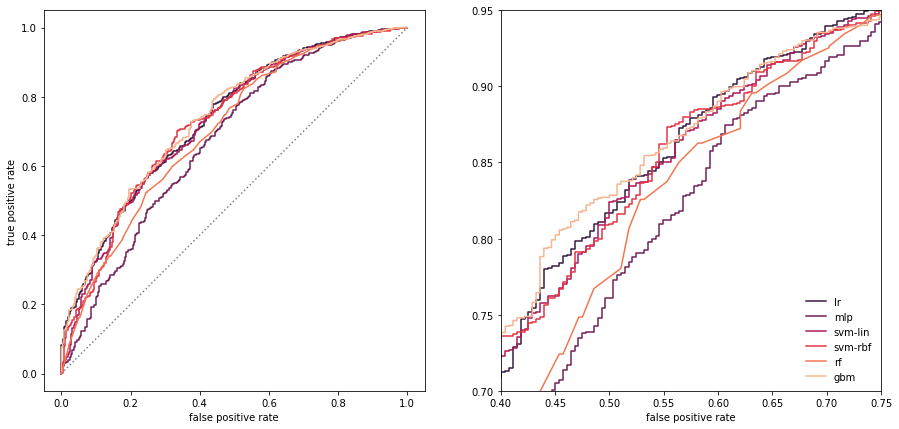

In [9]:
# test set auc_roc curves on the first fold
split_get = skf.split(classification_data.loc[:,features], classification_data.target_class)
train_ind, test_ind = next(split_get)
X_, y_ = classification_data.iloc[test_ind,:].loc[:,features],\
    classification_data.target_class.iloc[test_ind]
    
roc_ls = []
for k, p in score_dict.items():
    fpr, tpr, thre = roc_curve(y_, p["estimator"][0].predict_proba(X_)[:,1])
    df = pd.DataFrame([fpr,tpr]).T.apply(pd.to_numeric)
    df["pipe"] = k
    roc_ls.append(df)
roc_df = pd.concat(roc_ls)
roc_df.columns = ["fpr","tpr","pipe"]   

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.lineplot("fpr","tpr", hue="pipe", data=roc_df, ax=axs[0],
    palette="rocket", hue_order=pipe_order,
    estimator=None, legend=False);

sns.lineplot([0,1],[0,1], color="grey", ax=axs[0], linestyle="dotted", legend=False);

sns.lineplot("fpr","tpr", hue="pipe", data=roc_df, ax=axs[1], palette="rocket",
    hue_order=pipe_order, estimator=None,);

axs[0].set_ylabel("true positive rate");
axs[0].set_xlabel("false positive rate");
axs[1].set_ylim(0.7,0.95);
axs[1].set_xlim(0.4,0.75);     
axs[1].set_ylabel("");
axs[1].set_xlabel("false positive rate"); 
axs[1].legend(loc="lower right", frameon=False);
plt.show();

On the left, we can observe relationship amongst the overall roc_auc curves. The `mlp` & `rf` duo is underperforming across whole range of the fpr. On the right, we see the curves in a bit more detail.

In [10]:
pf = open("../data/benchmark-cache.pickle","wb")
pickle.dump([classification_data, skf, score_dict], pf)
pf.close()

# Next steps

**Feature importance**  
 * focus on the top performing algorithms,
 * ...

**Technical**
 * factor the workhorse funcs out of the ipynb,
 * improve caching,
 * ...

> Martin Fridrich, 03/2021